In [1]:
!pip install timm

# Making the necessary imports

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import timm
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from time import sleep

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating DataFrame of files and classes

In [3]:
import os
def create_df(path):
    df = pd.DataFrame(columns=["Path", "Class"])
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            df.loc[len(df)] = [os.path.join(path, folder, file), folder]
    return df

In [4]:
PATH = "/kaggle/input/stack-dataset/images"
test_df = create_df(f"{PATH}/final test")

# Encoding the class names to labels

In [5]:
le = LabelEncoder()
le.fit(test_df["Class"])
test_df["Class"] = le.transform(test_df["Class"])

In [6]:
test_df

,Path,Class
0,/kaggle/input/stack-dataset/images/final test/...,6
1,/kaggle/input/stack-dataset/images/final test/...,6
2,/kaggle/input/stack-dataset/images/final test/...,6
3,/kaggle/input/stack-dataset/images/final test/...,6
4,/kaggle/input/stack-dataset/images/final test/...,6
...,...,...
1895,/kaggle/input/stack-dataset/images/final test/...,3
1896,/kaggle/input/stack-dataset/images/final test/...,3
1897,/kaggle/input/stack-dataset/images/final test/...,3
1898,/kaggle/input/stack-dataset/images/final test/...,3


In [7]:
test_data = test_df

# Creating the Config for the testing

In [8]:
class CFG:
    model_names = ['wide_resnet50_2.tv2_in1k', 'regnetx_160.tv2_in1k', 'regnetx_320.tv2_in1k']
    size = 48
    n_epochs = 20
    lr = 0.001
    weight_decay = 0.001
    momentum = 0.9
    n_classes = 7
    batch_size = 256
    test = True

# Creating our custom dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["Path"].values
        self.labels = df["Class"].values
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        image = cv2.imread(self.file_names[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image = image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

# Defining our custom image augmentations based on type of dataset

In [10]:
def get_transform(*, data):
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.RandomResizedCrop(CFG.size, CFG.size),
            A.HorizontalFlip(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    elif data == 'test':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [84]:
class Model(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = timm.create_model(model, pretrained=True)
        if (self.model.default_cfg['classifier'] == "fc"):
            n_features = self.model.fc.in_features
        elif (self.model.default_cfg['classifier'] == "classifier"):
            n_features = self.model.classifier.in_features
        elif (self.model.default_cfg['classifier'] == "head.fc"):
            n_features = self.model.head.fc.in_features
        elif (self.model.default_cfg['classifier'] == "classif"):
            n_features = self.model.classif.in_features
        self.model.fc = nn.Linear(n_features, CFG.n_classes)
    def forward(self, x):
        return self.model(x)

## Metric

In [85]:
def get_score(y_true, y_pred):
    check = y_true - y_pred
    return np.count_nonzero(check == 0)/len(check)

# Ensemble Function

In [86]:
def ensemble(df):
    ensemble_output = list(df.mode(1).iloc[:, 0]) #max voting done using mode function in pandas suite
    for i in range(len(df)):
        outputs = list(df.iloc[i, :])
        if (outputs[0] != outputs[1] and outputs[1] != outputs[2]): #if none of the labels are equal
            mode = outputs[2] #select the label coming from prediction with maximum validation score
            ensemble_output[i] = mode
    return ensemble_output

# One shot testing

In [87]:
def test_fn(model, test_loader, device):
    model.eval()
    preds = []
    sum_losses = 0
    count = 0
    with tqdm(test_loader, unit="batch") as tepoch:
        for (inputs, labels) in tepoch:
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            preds.append(outputs.softmax(1).to('cpu').numpy())
            sleep(0.1)
    predictions = np.concatenate(preds)
    return predictions

# Our main testing loop

In [97]:
def test_loop(path):
    test_dataset = CustomDataset(test_data, transform=get_transform(data='test')) #test dataset class
    test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, drop_last=False) #test dataloader
    preds = []
    for model_name in CFG.model_names: #iterating over the models listed in CFG
        model = Model(model_name)
        model.to(device)
        check_point = torch.load(f'{path}/{model_name}_best.pth') #loading the model from given path
        model.load_state_dict(check_point['model'])
        predictions = test_fn(model, test_loader, device)
        test_labels = test_data["Class"].to_numpy().reshape(len(predictions), )
        score = get_score(test_labels, np.argmax(predictions, axis=1))*100 #evaluating the ground truth with predictions
        print(f"Model = {model_name}\nScore = {score: .4f} %")
        macro_f1 = f1_score(test_labels, np.argmax(predictions, axis=1), average='macro') #calculating macro f1 score over all classes (7 classes)
        print(f"Macro F1 Score = {macro_f1}\n")
        preds.append(np.argmax(predictions,axis=1))
    ensemble_output = pd.DataFrame(preds).transpose()
    ensemble_preds = ensemble(ensemble_output)
    ensemble_score = get_score(test_labels, ensemble_preds)*100 #calculating ensemble accuracy
    print(f"Ensemble Score = {ensemble_score}%")
    test_data['preds'] = ensemble_preds
    return test_data

# Main Function

In [98]:
def main():
    models_path = "/kaggle/input/stack-models"
    df = test_loop(models_path)
    cm = confusion_matrix(df["Class"], df["preds"]) #creating the confusion matrix with all the classes, ground truths and predicted labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) #displaying the confusion matrix
    disp.plot()
    plt.show()
    macro_f1 = f1_score(df["Class"], df["preds"], average='macro') #calculating ensemble macro f1 score
    print(f"\n\nEnsemble Macro F1 Score = {macro_f1}")

## Calling the main function

  0%|          | 0/8 [00:00<?, ?batch/s]

Model = wide_resnet50_2.tv2_in1k
Score =  61.3684 %
Macro F1 Score = 0.5943915252115023



  0%|          | 0/8 [00:00<?, ?batch/s]

Model = regnetx_160.tv2_in1k
Score =  62.1053 %
Macro F1 Score = 0.618630168864439



  0%|          | 0/8 [00:00<?, ?batch/s]

Model = regnetx_320.tv2_in1k
Score =  62.4737 %
Macro F1 Score = 0.6214245690003221

Ensemble Score = 64.52631578947368%


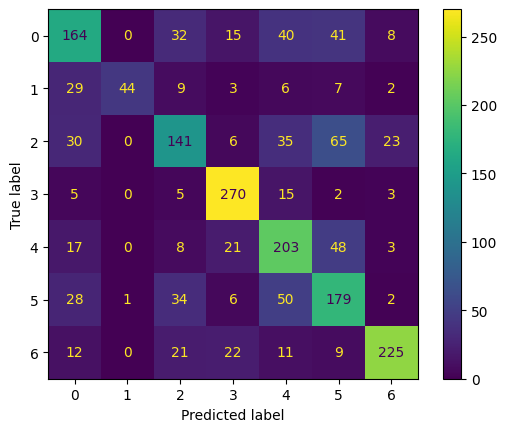



Ensemble Macro F1 Score = 0.6400355248157629


In [99]:
if __name__ == '__main__':
    main()